In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [87]:
files = [ 
    'offshore/TieBreaker File - 8 Dec 22.xlsx',
    'offshore/TieBreaker File - 9 Dec 22.xlsx',
    'offshore/TieBreaker File - 12 Dec 22.xlsx',
    'offshore/TieBreaker File - 13 Dec 22.xlsx',
    'offshore/TieBreaker File - 14 Dec 22.xlsx',
    'offshore/TieBreaker File - 15 Dec 22.xlsx',
    'offshore/TieBreaker File - 16 Dec 22.xlsx',
    'offshore/TieBreaker File - 19 Dec 22.xlsx'
]

In [88]:
df = pd.concat([pd.read_excel(i) for i in files])[['Sr No', 'query', 'sample_method', 'gmv', 'cnt', 
    'Tiebreaked All SortedByConfidenceHighestFirst taxonomy path Full Paths']].rename( 
        columns={
            'Sr No': 'label_ordering', 
            'Tiebreaked All SortedByConfidenceHighestFirst taxonomy path Full Paths': 'query_classifications'}
    )
assert len(df) == len(set(df['query']))
df['label_ordering'] = df['label_ordering'].astype(int)

In [89]:
df_tax = pd.read_json('../taxonomy/wish_newtax.json', lines=True)
df_tax = df_tax[df_tax.category_path.apply(len) > 0]
errors = []
class Trie:
    def __init__(self):
        self.trie = {}

    def add_text(self, text):
        node = self.trie
        for ind, i in enumerate(text):
            if i not in node:
                node[i] = {}
            node = node[i]
            if ind == len(text) - 1:
                node['<EOS>'] = 1
    
    def extract_from_text(self, text):
        node = self.trie
        res = []
        cur_res = ''
        for ind, i in enumerate(text):
            if i in node:
                node = node[i]
                cur_res += i
            else:
                try:
                    assert '<EOS>' in node
                except:
                    print('ERROR: ', text, res)
                    errors.append(text)
                    return None
                res.append(cur_res)
                cur_res = ''
                node = self.trie
        if len(cur_res) > 0:
            res.append(cur_res)
        
        return res
trie = Trie()
for i in df_tax.category_path.apply(lambda x: x.strip()).tolist():
    trie.add_text(i)
for i in df_tax.category_path.apply(lambda x: x.strip().lower()).tolist():
    trie.add_text(i)
trie.add_text('nan')
trie.add_text('No Categories Match')

In [90]:
manual_correction = {
    "Beauty & Health > Sexual Wellness > Sex Toys,Beauty & Health > Sexual Wellness > SM Products ,nan": \
        "Beauty & Health > Sexual Wellness > Sex Toys,Beauty & Health > Sexual Wellness > SM Products,nan",
    "Apparel Accessories > Girls' Accessories > Girls' Hair Accessories -,Apparel Accessories > Women's Hair Accessories,sports > fitness & body building > yoga > yoga hair bands": \
        "Apparel Accessories > Girls' Accessories > Girls' Hair Accessories,Apparel Accessories > Women's Hair Accessories,sports > fitness & body building > yoga > yoga hair bands",
    "Women's Clothing > Dresses ,women's clothing > weddings & events > wedding dresses,mother & kids > pregnancy & maternity > dresses": \
        "Women's Clothing > Dresses,women's clothing > weddings & events > wedding dresses,mother & kids > pregnancy & maternity > dresses",
    "Women's Clothing > Dresses, Mother & Kids > Girls' Baby Clothing > Dresses,Mother & Kids > Pregnancy & Maternity > Dresses": \
        "Women's Clothing > Dresses,Mother & Kids > Girls' Baby Clothing > Dresses,Mother & Kids > Pregnancy & Maternity > Dresses", 
    "Home & Garden > Arts, Crafts & Sewing > Apparel Sewing & Fabric > Buttons,Retrieving data. Wait a few seconds and try to cut or copy again.,nan": \
        "Home & Garden > Arts, Crafts & Sewing > Apparel Sewing & Fabric > Buttons,nan,nan",
    "Men's Clothing > Tops & Tees > T-Shirts,Watches > Men's Watches > Quartz Watch,Home & Garden > Kitchen,Dining & Bar > Coffeeware > Coffee Cups & Mugs": \
         "Men's Clothing > Tops & Tees > T-Shirts,Watches > Men's Watches > Quartz Watches,Home & Garden > Kitchen,Dining & Bar > Coffeeware > Coffee Cups & Mugs",
    "education & office supplies > writing & correction supplies > stencils,Crafts & Sewing > Scrapbooking & Stamping > Cutting Dies,home & garden > arts, crafts & sewing > apparel sewing & fabric > diy craft supplies": \
        "education & office supplies > writing & correction supplies > stencils,Home & Garden > Arts, Crafts & Sewing > Scrapbooking & Stamping > Cutting Dies,home & garden > arts, crafts & sewing > apparel sewing & fabric > diy craft supplies",
    "Home & Garden > Home Decor > Painting & Calligraphy,Home Improvement > Painting Supplies & Wall Treatments > Wallpapers,Home & Garden > Home Decor > Wall Sticker": \
        "Home & Garden > Home Decor > Painting & Calligraphy,Home Improvement > Painting Supplies & Wall Treatments > Wallpapers,Home & Garden > Home Decor > Wall Stickers",
    "Computer & Office > Office Electronics > Printer,Computer & Office > Office Electronics > All in One Printer,Education & Office Supplies > Paper > Printer Paper": \
        "Computer & Office > Office Electronics > Printers,Computer & Office > Office Electronics > All in One Printer,Education & Office Supplies > Paper > Printer Paper",
    "Home & Garden > Home Textile > Bedding > Pillow Cases, Home & Garden > Home Textile > Bedding > Quilts,Home & Garden > Home Textile > Duvet Cover Sets": \
        "Home & Garden > Home Textile > Bedding > Pillow Cases,Home & Garden > Home Textile > Bedding > Quilts,Home & Garden > Home Textile > Duvet Cover Sets",
    "Accessories > Earrings >\xa0Hoop Earrings,nan,nan": "Jewelry & Accessories > Earrings > Hoop Earrings,nan,nan", 
    "Shoes > Men's Shoes > Men's Boots,Shoes > Women's Shoes > Women's Boots,Children's Shoes > Boys > Boots Mother & Kids > Children's Shoes > Boys > Boots": \
        "Shoes > Men's Shoes > Men's Boots,Shoes > Women's Shoes > Women's Boots,Mother & Kids > Children's Shoes > Boys > Boots",
    "Beauty & Health > Sexual Wellness > SM Products > Bondage Gear,Beauty & Health > Sexual Wellness ,nan": \
        "Beauty & Health > Sexual Wellness > SM Products > Bondage Gear,Beauty & Health > Sexual Wellness,nan"
}

In [91]:
df['query_classifications'] = df.query_classifications.apply(lambda x: x.strip().replace('\n', '').replace('| ',',').replace('|',',')).apply(
    lambda x: manual_correction[x] if x in manual_correction else x)

In [92]:
df['query_classification_lists'] = df.query_classifications.apply(trie.extract_from_text)

ERROR:  Apparel Accessories > Girls' Accessories > Girls' Hats,Apparel Accessories > Women's Hats,Apparel Accessories > Girls' Accessories > Girls' Hats, Scarves & Gloves Sets []


In [93]:
errors

["Apparel Accessories > Girls' Accessories > Girls' Hats,Apparel Accessories > Women's Hats,Apparel Accessories > Girls' Accessories > Girls' Hats, Scarves & Gloves Sets"]

In [94]:
recs = []
for i in df.to_dict('records'):
    if i['query_classifications'] == errors[0]:
        i['query_classification_lists'] = [
            "Apparel Accessories > Girls' Accessories > Girls' Hats",
            "Apparel Accessories > Women's Hats",
            "Apparel Accessories > Girls' Accessories > Girls' Hats, Scarves & Gloves Sets"
        ]
    recs.append(i)
df = pd.DataFrame(recs)

In [95]:
path2id = {}
for i in df_tax.to_dict('records'):
    path2id[i['category_path'].lower().strip()] = i['id']
    path2id[i['category_path'].strip()] = i['id']
id2path = {}
for i in df_tax.to_dict('records'):
    id2path[i['id']] = i['category_path']

In [96]:
path2id['nan'] = -1
path2id['No Categories Match'] = -1

In [97]:
df['query_classification_ids'] = df['query_classification_lists'].apply(lambda x: [path2id[i] for i in x])

In [98]:
def convert_id_to_path(li):
    if set(li) == set([-1]):
        return []
    else:
        res = [] 
        for i in li:
            if int(i) in id2path:
                res.append(id2path[int(i)])
        return res

In [99]:
df['query_classification_lists'] = df['query_classification_ids'].apply(convert_id_to_path).apply(tuple)

<AxesSubplot: ylabel='Frequency'>

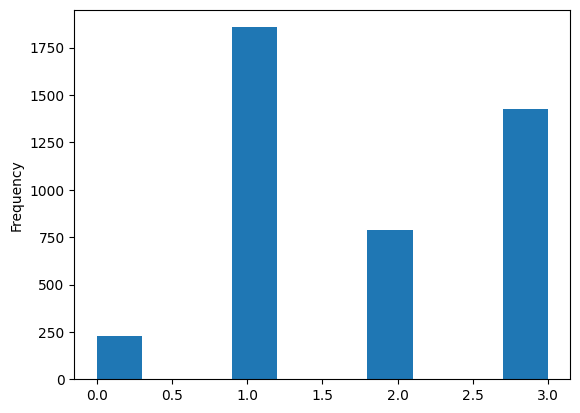

In [100]:
df.query_classification_lists.apply(len).plot.hist()

<AxesSubplot: ylabel='sample_method'>

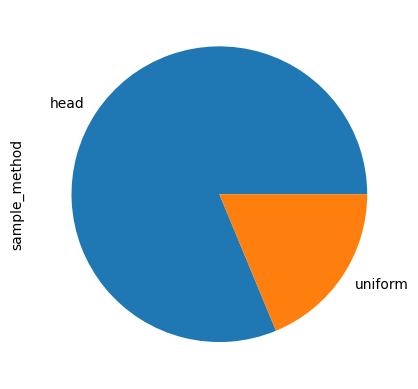

In [101]:
df.sample_method.value_counts().plot.pie()

<AxesSubplot: ylabel='Frequency'>

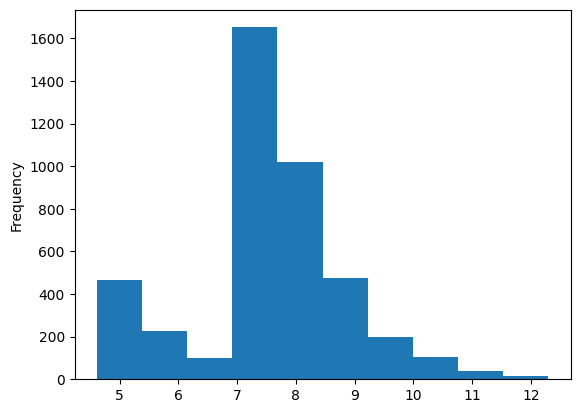

In [102]:
df.cnt.apply(np.log).plot.hist()

<AxesSubplot: ylabel='Frequency'>

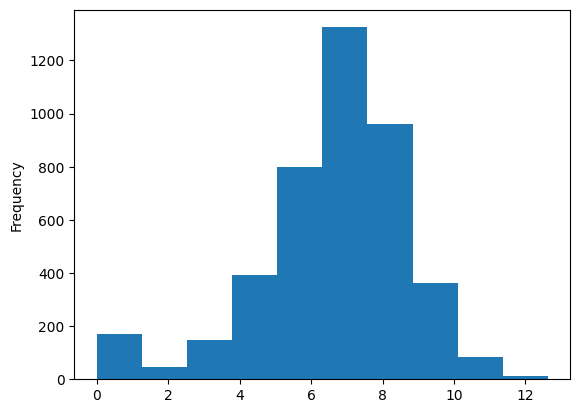

In [103]:
df.gmv.apply(lambda x: np.log(x + 1)).plot.hist()

<AxesSubplot: ylabel='query_classification_lists'>

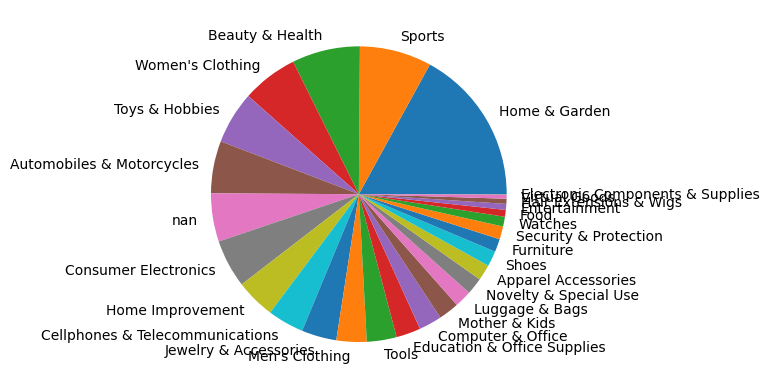

In [104]:
plt.axis('off')
df['query_classification_lists'].apply(lambda x: x[0].split(" > ")[0] if len(x) > 0 else 'nan').value_counts().plot.pie()

In [106]:
len(df)

4300

In [108]:
df.to_excel('processed/tmp_Offshore_Labelled_Query_Classification_Test.xlsx', index=False)

In [109]:
# after google sheet translate
tmp = pd.read_excel('processed/tmp_Offshore_Labelled_Query_Classification_Test_wLang.xlsx')

In [113]:
df['lang'] = tmp['lang'].tolist()

<AxesSubplot: ylabel='lang'>

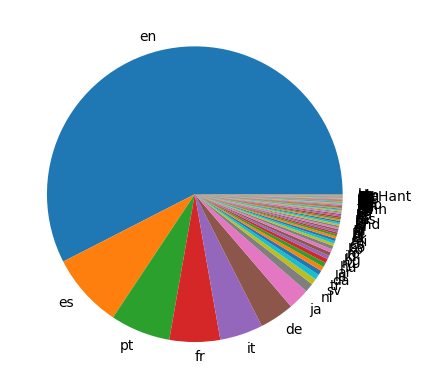

In [115]:
plt.axis('off')
df['lang'].value_counts().plot.pie()

In [116]:
df.to_json('processed/Offshore_Labelled_Query_Classification_Test.json', orient='records', 
    lines=True)